<IPython.core.display.Javascript object>


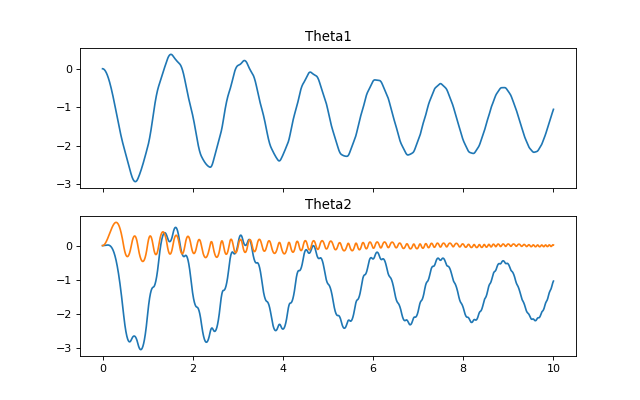

<IPython.core.display.Javascript object>


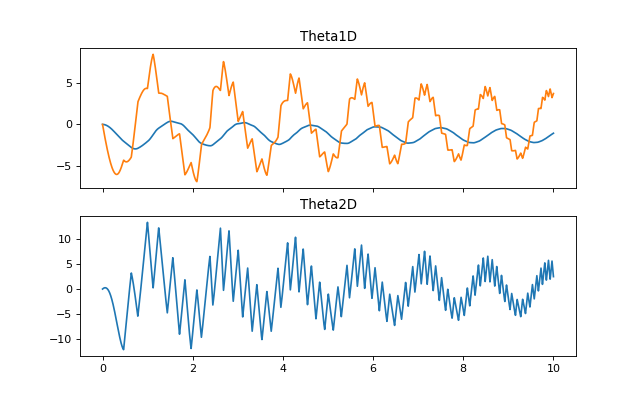

<IPython.core.display.Javascript object>


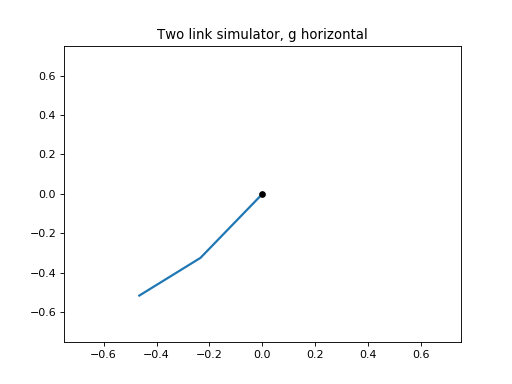

In [335]:
# With joint stiffness and damping

from scipy.integrate import odeint
from math import pi
import numpy as np
from math import sin 
from math import cos
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# %matplotlib notebook


# Parameter of arm
g =  -9.81   # m/s/s
m1 = 3.5    # kg
l1 = 0.4  # metres
I1 = (m1 * l1**2)/12  # kg m**2
m2 = 2    # kg
l2 = 0.3  # metres
I2 = (m1 * l1**2)/12  # kg m**2    
T1e = 0     # Nm
T1f = 0     # Nm
T2e = 0   
T2f = 0

# Joint parameters
shoulderK = 8  # N/rad
elbowK    = 2
shoulderB = 1  # N/rad/s
elbowB    = 1  # N/rad/s

def j_friction(state):
    theta1  = state[2]
    theta2  = state[5]
    theta1D = state[7]
    theta2D = state[9]
    elbowFriction = -elbowK*(theta2-theta1) - elbowB*(theta2D-theta1D)
    shoulderFriction = -shoulderB*theta1D
    # Shoulder
    if -110*pi/180/2<theta1<-120*pi/180:
        shoulderFriction = shoulderFriction - shoulderK*theta1    
    # Elbow
    if theta2-theta1< 0*pi/180:
        elbowFriction = 6
    elif theta2-theta1 > 60*pi/180:
        elbowFriction = -6

    return elbowFriction, shoulderFriction

def twojointmuscle(state,t):

    theta1  = state[2]
    theta2  = state[5]
    theta1D = state[7]
    theta2D = state[9]
    vel     = state[6:]
    
    # Mass matrix
    M = np.diag([m1,m1,I1,m2,m2,I2])
    B = np.array([[-1, 0, 1, 0],
         [0, -1, 0, 1],
         [-l1*sin(theta1)*0.5,l1*cos(theta1)*0.5,-l1*sin(theta1)*0.5,l1*cos(theta1)*0.5],
         [0, 0, -1, 0],
         [0, 0, 0, -1],
         [0, 0, -l2*sin(theta2)*0.5, l2*cos(theta2)*0.5]])
    A = np.transpose(B)
    Z = np.zeros((4,4))
    A = np.concatenate((A,Z),axis=1)
    DAE = np.concatenate((M,B),axis=1)
    DAE = np.concatenate((DAE,A),axis=0)
    
    # Get friction value
    eF,sF = j_friction(state,)
    # Get torque from data set
    
    # Optimize muscle forces
    
    # Calculate muscle feedback proportional to theta,thetad
    
    # Force feedback
    
    # Create feedback vector
    fv  = np.array([0,
                    m1*g,
                    T1e-T1f+T2f-T2e + sF,
                    0,
                    m2*g,
                    T2e-T2f + eF,
                    0.5*l1*cos(theta1)*theta1D**2,
                    0.5*l1*sin(theta1)*theta1D**2,
                    0.5*l1*cos(theta1)*theta1D**2 + 0.5*l2*cos(theta2)*theta2D**2,
                    0.5*l1*sin(theta1)*theta1D**2 + 0.5*l2*sin(theta2)*theta2D**2])
    # Evaluate in LLS
    DAEinv = np.linalg.inv(DAE)
    acc = DAEinv @ fv
    outputstate = np.concatenate((vel,acc[:6]),axis=0)
    return outputstate

def posfromangles(t1,t2):
    x1 = 0.5*l1*cos(t1)
    y1 = 0.5*l1*sin(t1)
    x2 = 2*x1 + 0.5*l2*cos(t2)
    y2 = 2*y1 + 0.5*l2*sin(t2)
    pos = np.array([x1, y1, t1, x2, y2, t2])
    return pos

def velfromangles(t1,t2,td1,td2):
    vx1 = -0.5*l1*sin(t1)*td1
    vy1 = 0.5*l1*cos(t1)*td1
    vx2 = vx1 - 0.5*l1*sin(t1)*td1 - 0.5*l2*sin(t2)*td2
    vy2 = vy1 + 0.5*l1*cos(t1)*td1 + 0.5*l2*cos(t2)*td2
    vel = np.array([vx1, vy1, td1, vx2, vy2, td2])
    return vel

pos = posfromangles(0,0)
vel = velfromangles(pos[2],pos[5],0,0)

# Define state0
state0 = np.concatenate((pos,vel))
state0 = np.transpose(state0)

# Integrate
Tsim = 10
Nspaces = 5000
dt = Tsim/Nspaces
t = np.linspace(0,Tsim,Nspaces)   
state = odeint(twojointmuscle, state0, t)

# Plot
fig1, (ax1, ax2) = plt.subplots(2, sharex=True,figsize=(8,5))
ax1.plot(t, state[:,2])
ax1.title.set_text("Theta1")
ax2.plot(t, state[:,5])
ax2.plot(t, state[:,5]-state[:,2])
ax2.title.set_text("Theta2")


fig2, (ax1, ax2) = plt.subplots(2, sharex=True,figsize=(8,5))
ax1.plot(t, state[:,2])
ax1.plot(t, state[:,8])
ax1.title.set_text("Theta1D")
ax2.plot(t, state[:,11])
ax2.title.set_text("Theta2D")




# Plot
figf = plt.figure()
ax = plt.axes(xlim = (-(l1+l2)-.05,l1+l2+.05),ylim = (-(l1+l2)-.05,l1+l2 +.05))
line, = plt.plot([], [], linewidth=2)
ax.set_title("Two link simulator, g horizontal")
plt.plot(0,0,'k.',markersize=10)
plt.plot((-1,1,1,-1,-1),(-1,-1,1,1,-1),'k-',linewidth=0.5)

def init():    
    line.set_data([], [])
    return line,
def animate(i):
    xA = [0,l1*np.cos(state[i,2])]
    yA = [0,l1*np.sin(state[i,2])]
    xB = [xA[1],xA[1]+l2*np.cos(state[i,5])]
    yB = [yA[1],yA[1]+l2*np.sin(state[i,5])]
    line.set_data([xA,xB], [yA,yB])
    return line,

anim = animation.FuncAnimation(figf, animate, init_func=init,
                               frames=100000, interval=10, blit=True, 
                               repeat_delay = 2000)
